In [1]:
# import the necessary libraries 
import numpy as np 
import tensorflow as tf 
import matplotlib.pyplot as plt 
from tensorflow import keras

In [2]:
print(tf.__version__)

2.14.0


In [22]:
gpus = tf.config.experimental.list_physical_devices("GPU")
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
gpu=tf.config.experimental.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(gpu[0],True)

In [4]:
(trainData,trainLabels),(testData,testLabels)=tf.keras.datasets.mnist.load_data()

In [5]:
image_height=28
image_width=28
num_classes=10
image_channels=1

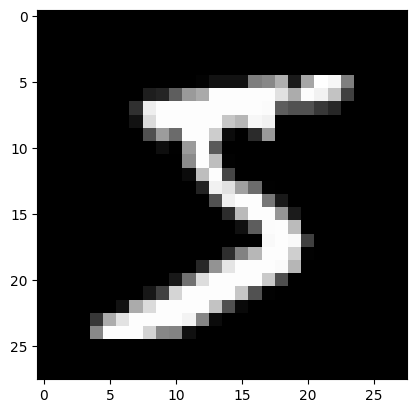

In [6]:
plt.imshow(trainData[0],cmap="binary_r")

In [7]:
td=trainData.reshape(trainData.shape[0],image_height,image_width,image_channels)
ted=testData.reshape(testData.shape[0],image_height,image_width,image_channels)

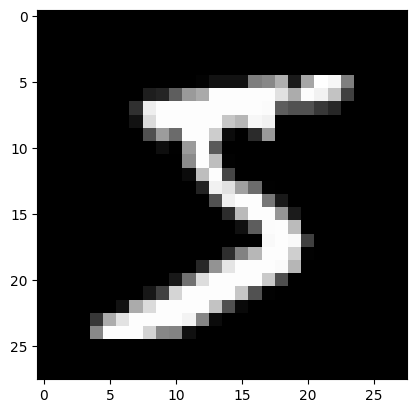

In [8]:
td=td/255.0  # here it should be changed from dtype("float64 to float32") if any problem arises
ted=ted/255.0
plt.imshow(td[0],cmap="binary_r")

In [9]:
td=np.pad(td,((0,0),(2,2),(2,2),(0,0)))
ted=np.pad(ted,((0,0),(2,2),(2,2),(0,0)))

In [10]:
td.shape
tl=trainLabels
tel=testLabels


In [11]:
image_height=32
image_width=32
image_channels=1
num_classes=10


In [12]:
from tensorflow.keras import backend, models,layers
class LeNet:
    #input=> conv->tanh->avg-pool->conv->tanh->avg-pool->fully_connected->tanh->fullyconnected-tanh->fc->softmax
    @staticmethod
    #its in constructor so if we call multiple Lenet it will not output again & again
    def __init__(numChannels,imgRows,imgCols,numClasses,weightsPath=None):
        if backend.image_data_format() == "channels_first":
            inputShape=(numChannels,imgRows,imgCols)
        else:
            inputShape=(imgRows,imgCols,numChannels)
        
        model=models.Sequential()
        #initialize the model
        model.add(layers.Conv2D(filters=6, kernel_size=(5,5),strides=(1,1),
                                padding="valid",activation=tf.nn.tanh, input_shape=inputShape))
        model.add(layers.AveragePooling2D(pool_size=(2,2), strides=(2,2)))
        model.add(layers.Conv2D(filters=16,kernel_size=(5,5),strides=(1,1),
                               padding="valid",activation=tf.nn.tanh, ))
        model.add(layers.AveragePooling2D(pool_size=(2,2),strides=(2,2)))
        model.add(layers.Flatten())
        model.add(layers.Dense(units=120, activation=tf.nn.tanh))
        model.add(layers.Dense(units=84, activation=tf.nn.tanh))
        model.add(layers.Dense(units=numClasses, activation=tf.nn.softmax))
        if weightsPath is not None:
            model.load_weights(weightsPath)
        return model
    

In [13]:
model=LeNet.__init__(numChannels=image_channels, imgRows=image_height,
            imgCols=image_width,
            numClasses=10,
           weightsPath="LeNetMNIST.temp.hdf5")
#compile the model
model.compile(optimizer=tf.keras.optimizers.SGD(lr=0.01),
             loss="sparse_categorical_crossentropy",
             metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 6)         156       
                                                                 
 average_pooling2d (Average  (None, 14, 14, 6)         0         
 Pooling2D)                                                      
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 16)        2416      
                                                                 
 average_pooling2d_1 (Avera  (None, 5, 5, 16)          0         
 gePooling2D)                                                    
                                                                 
 flatten (Flatten)           (None, 400)               0         
                                                                 
 dense (Dense)               (None, 120)               4

In [14]:
#callback function for training termination criteria
#accuracy_cutoff
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self,epoch,logs=None):
        if(logs.get('accuracy')>0.99):
            self.model.stop_training=True

        
batch_size=120
epochs=100
history=model.fit(x=td,y=tl,validation_data=(ted,tel),
                 batch_size=batch_size, epochs=epochs, verbose=1,
                 callbacks=[myCallback()])

Epoch 1/100
500/500 [==============================] - 9s 16ms/step - loss: 0.0348 - accuracy: 0.9900 - val_loss: 0.0445 - val_accuracy: 0.9858
Epoch 2/100
500/500 [==============================] - 8s 16ms/step - loss: 0.0343 - accuracy: 0.9907 - val_loss: 0.0453 - val_accuracy: 0.9856


In [15]:
model.save_weights("LeNetMNIST.temp.hdf5",overwrite=True)

# so we dont have to train again and again.

In [16]:
(loss,accuracy)= model.evaluate(ted,tel,batch_size=batch_size,verbose=1)

84/84 [==============================] - 1s 7ms/step - loss: 0.0453 - accuracy: 0.9856


In [17]:
model=LeNet.__init__(numChannels=image_channels,
                     imgRows=image_height,
                    imgCols=image_width,
                    numClasses=num_classes,
                    weightsPath="LeNetMNIST.temp.hdf5")
model.compile(optimizer=tf.keras.optimizers.SGD(lr=0.01),
loss="sparse_categorical_crossentropy",
metrics=["accuracy"])

In [18]:
loss,accuracy=model.evaluate(ted,tel)
print("accuracy: ",accuracy*100,"%")

313/313 [==============================] - 1s 2ms/step - loss: 0.0453 - accuracy: 0.9856
accuracy:  98.55999946594238 %


1/1 [==============================] - 0s 66ms/step


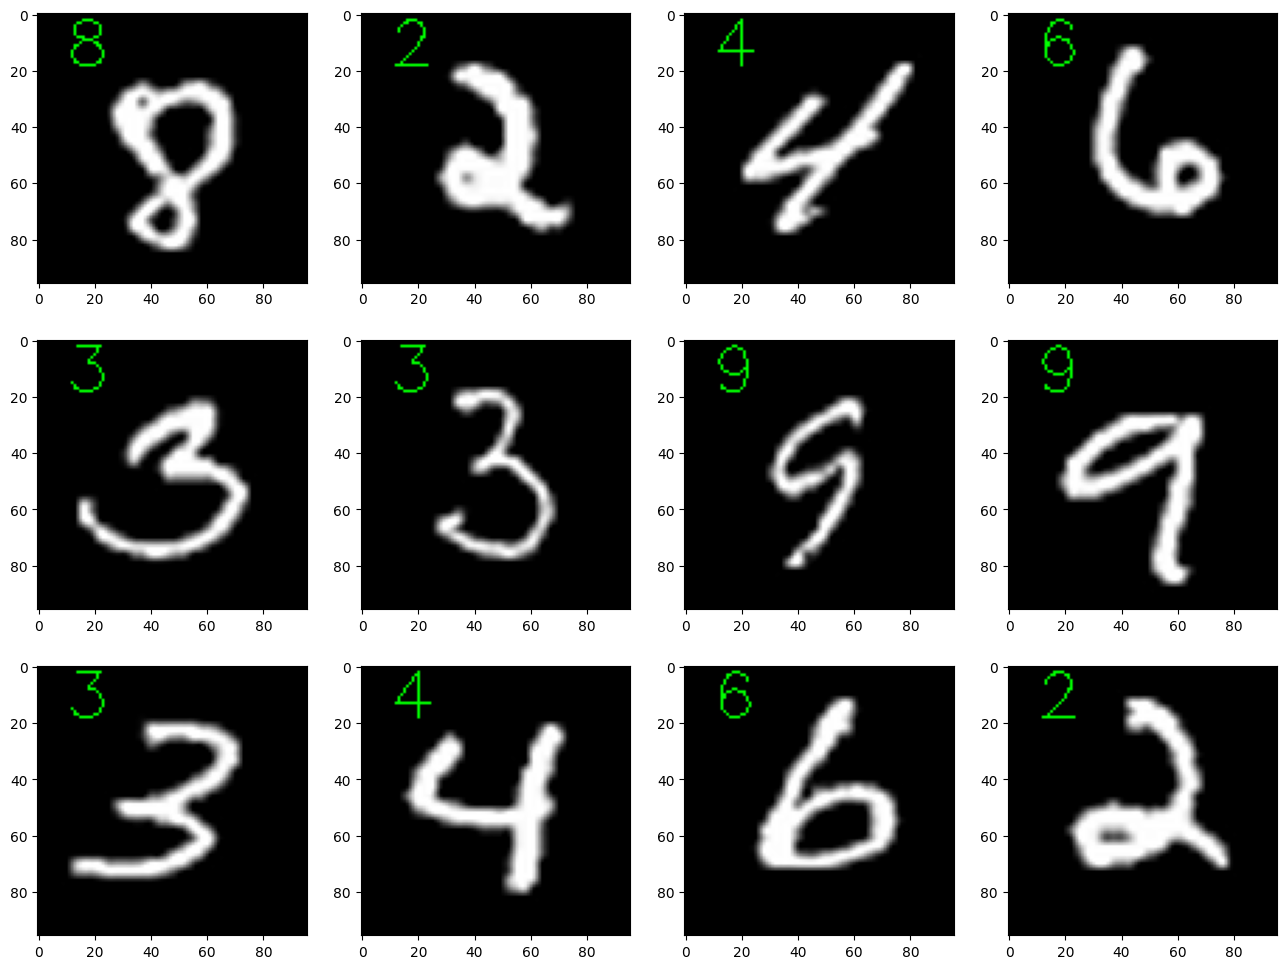

In [19]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import cv2

nrows=3
ncols=4
fig=plt.gcf()
fig.set_size_inches(ncols*4,nrows*4)
num_predictions=12
test_indices=np.random.choice(np.arange(0,len(tel)),size=(num_predictions,))
test_imgs=np.stack(([ted[i] for i in test_indices]))
test_labels=np.stack(([tel[i] for i in test_indices]))

predictions=model.predict(test_imgs)
for i in range(num_predictions):
    prediction=np.argmax(predictions[i])
    image=(test_imgs[i]*255).astype("uint8")
    image=cv2.resize(image,(96,96),interpolation=cv2.INTER_CUBIC)
    image=cv2.merge([image]*3)
    if prediction==test_labels[i]:
        rgb_color=(0,255,0)
    else:
        rgb_color=(255,0,0)
    cv2.putText(image,str(prediction),(10,18),
               cv2.FONT_HERSHEY_SIMPLEX,0.75,rgb_color,1)
    sp=plt.subplot(nrows,ncols,i+1,)
    plt.imshow(image)
plt.show()

In [21]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

pre_trained_model= InceptionV3(input_shape=(150,150,3),
                              include_top=False,
                              weights=None)
pre_trained_weights_file=""
# pre_trained_model.load_weights(pre_trained_weights_file)
# pre_trained_model.trainable=False
pre_trained_model.summary()


Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv2d_98 (Conv2D)          (None, 74, 74, 32)           864       ['input_2[0][0]']             
                                                                                                  
 batch_normalization_94 (Ba  (None, 74, 74, 32)           96        ['conv2d_98[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_94 (Activation)  (None, 74, 74, 32)           0         ['batch_normalizati

                                                                                                  
 conv2d_109 (Conv2D)         (None, 16, 16, 32)           6144      ['average_pooling2d_13[0][0]']
                                                                                                  
 batch_normalization_99 (Ba  (None, 16, 16, 64)           192       ['conv2d_103[0][0]']          
 tchNormalization)                                                                                
                                                                                                  
 batch_normalization_101 (B  (None, 16, 16, 64)           192       ['conv2d_105[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 batch_normalization_104 (B  (None, 16, 16, 96)           288       ['conv2d_108[0][0]']          
 atchNorma

 )                                                                  ]']                           
                                                                                                  
 activation_111 (Activation  (None, 16, 16, 96)           0         ['batch_normalization_111[0][0
 )                                                                  ]']                           
                                                                                                  
 activation_112 (Activation  (None, 16, 16, 64)           0         ['batch_normalization_112[0][0
 )                                                                  ]']                           
                                                                                                  
 mixed1 (Concatenate)        (None, 16, 16, 288)          0         ['activation_106[0][0]',      
                                                                     'activation_108[0][0]',      
          

 )                                                                  ]']                           
                                                                                                  
 conv2d_126 (Conv2D)         (None, 16, 16, 96)           55296     ['activation_121[0][0]']      
                                                                                                  
 batch_normalization_122 (B  (None, 16, 16, 96)           288       ['conv2d_126[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_122 (Activation  (None, 16, 16, 96)           0         ['batch_normalization_122[0][0
 )                                                                  ]']                           
                                                                                                  
 conv2d_12

                                                                                                  
 conv2d_128 (Conv2D)         (None, 7, 7, 192)            147456    ['mixed3[0][0]']              
                                                                                                  
 conv2d_131 (Conv2D)         (None, 7, 7, 192)            172032    ['activation_126[0][0]']      
                                                                                                  
 conv2d_136 (Conv2D)         (None, 7, 7, 192)            172032    ['activation_131[0][0]']      
                                                                                                  
 conv2d_137 (Conv2D)         (None, 7, 7, 192)            147456    ['average_pooling2d_16[0][0]']
                                                                                                  
 batch_normalization_124 (B  (None, 7, 7, 192)            576       ['conv2d_128[0][0]']          
 atchNorma

 activation_141 (Activation  (None, 7, 7, 160)            0         ['batch_normalization_141[0][0
 )                                                                  ]']                           
                                                                                                  
 average_pooling2d_17 (Aver  (None, 7, 7, 768)            0         ['mixed4[0][0]']              
 agePooling2D)                                                                                    
                                                                                                  
 conv2d_138 (Conv2D)         (None, 7, 7, 192)            147456    ['mixed4[0][0]']              
                                                                                                  
 conv2d_141 (Conv2D)         (None, 7, 7, 192)            215040    ['activation_136[0][0]']      
                                                                                                  
 conv2d_14

 atchNormalization)                                                                               
                                                                                                  
 activation_146 (Activation  (None, 7, 7, 160)            0         ['batch_normalization_146[0][0
 )                                                                  ]']                           
                                                                                                  
 activation_151 (Activation  (None, 7, 7, 160)            0         ['batch_normalization_151[0][0
 )                                                                  ]']                           
                                                                                                  
 average_pooling2d_18 (Aver  (None, 7, 7, 768)            0         ['mixed5[0][0]']              
 agePooling2D)                                                                                    
          

                                                                                                  
 batch_normalization_156 (B  (None, 7, 7, 192)            576       ['conv2d_160[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 batch_normalization_161 (B  (None, 7, 7, 192)            576       ['conv2d_165[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_156 (Activation  (None, 7, 7, 192)            0         ['batch_normalization_156[0][0
 )                                                                  ]']                           
                                                                                                  
 activatio

 )                                                                  ]']                           
                                                                                                  
 conv2d_169 (Conv2D)         (None, 3, 3, 320)            552960    ['activation_164[0][0]']      
                                                                                                  
 conv2d_173 (Conv2D)         (None, 3, 3, 192)            331776    ['activation_168[0][0]']      
                                                                                                  
 batch_normalization_165 (B  (None, 3, 3, 320)            960       ['conv2d_169[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 batch_normalization_169 (B  (None, 3, 3, 192)            576       ['conv2d_173[0][0]']          
 atchNorma

 )                                                                  ]']                           
                                                                                                  
 activation_176 (Activation  (None, 3, 3, 384)            0         ['batch_normalization_176[0][0
 )                                                                  ]']                           
                                                                                                  
 activation_177 (Activation  (None, 3, 3, 384)            0         ['batch_normalization_177[0][0
 )                                                                  ]']                           
                                                                                                  
 batch_normalization_178 (B  (None, 3, 3, 192)            576       ['conv2d_182[0][0]']          
 atchNormalization)                                                                               
          

 )                                                                  ]']                           
                                                                                                  
 activation_182 (Activation  (None, 3, 3, 384)            0         ['batch_normalization_182[0][0
 )                                                                  ]']                           
                                                                                                  
 activation_185 (Activation  (None, 3, 3, 384)            0         ['batch_normalization_185[0][0
 )                                                                  ]']                           
                                                                                                  
 activation_186 (Activation  (None, 3, 3, 384)            0         ['batch_normalization_186[0][0
 )                                                                  ]']                           
          